In [81]:
include("../Inversion/Plot.jl")
include("../Inversion/KalmanInversion.jl")
include("Linear.jl")

forward_aug (generic function with 1 method)

# Two Parameter Linear Inverse Problems

Consider the 2-parameter linear inverse problem
$$y = G\theta + \eta.$$
with $\eta \sim \mathcal{N}(0, 0.1^2I)$. We explore the following three scenarios

#### non-singular (well-determined) system (NS) 
   $$
   y = \begin{bmatrix}
        3 \\
        7 
       \end{bmatrix} \quad
       G = \begin{bmatrix}
        1 & 2\\
        3 & 4
    \end{bmatrix} \quad
    \theta_{ref} = \begin{bmatrix}
        1 \\
        1 
       \end{bmatrix};
   $$ 
   
#### over-determined system (OD)
$$ y = \begin{bmatrix}
        3 \\
        7 \\
        10
       \end{bmatrix} \quad
       G = \begin{bmatrix}
        1 & 2\\
        3 & 4 \\
        5 & 6
    \end{bmatrix} \quad
    \theta_{ref} = \begin{bmatrix}
        1/3 \\
        17/12
       \end{bmatrix};
$$ 
   
#### under-determined system (UD)
$$
y = \begin{bmatrix}
        3
       \end{bmatrix} \quad
       G = \begin{bmatrix}
        1 & 2\\
    \end{bmatrix} \quad
       \theta_{ref} = \begin{bmatrix}
        1 \\
        1 
       \end{bmatrix}
       + c\begin{bmatrix}
        2 \\
        -1 
       \end{bmatrix}, \,\,c \in \mathcal{R}.
$$
   
We define $$\displaystyle \theta_{ref} = argmin_{\theta}\frac{1}{2}\lVert\Sigma_{\eta}^{-\frac{1}{2}}(y - G\theta)\rVert^2,$$ and 
note that, in the UD case, $\theta_{ref}$ comprises a one-parameter family of possible solutions. We also note that $y = G\theta_{ref}$ for NS; and 
$y = G\theta_{ref}(c^\dagger)$ for UD, with $c^{\dagger}=0$; but for OD $y \ne  G\theta_{ref}.$ 

In [82]:
function Two_Param_Linear_Test(problem_type::String, θ0_bar, θθ0_cov)
    
    N_θ = length(θ0_bar)

    
    if problem_type == "under-determined"
        # under-determined case
        θ_ref = [0.6, 1.2]
        G = [1.0 2.0;]
        
        y = [3.0;]
        Σ_η = Array(Diagonal(fill(0.1^2, size(y))))
        
        
    
    elseif problem_type == "over-determined"
        # over-determined case
        θ_ref = [1/3, 8.5/6]
        G = [1.0 2.0; 3.0 4.0; 5.0 6.0]
        
        y = [3.0;7.0;10.0]
        Σ_η = Array(Diagonal(fill(0.1^2, size(y))))
        
    elseif problem_type == "Hilbert"

        G = zeros(N_θ, N_θ)
        for i = 1:N_θ
            for j = 1:N_θ
                G[i,j] = 1/(i + j - 1)
            end
        end
    
        θ_ref = fill(1.0, N_θ)
        y   = G*θ_ref 
        Σ_η = Array(Diagonal(fill(0.5^2, N_θ)))
        
        
    else
        error("Problem type : ", problem_type, " has not implemented!")
    end
    
    Σ_post = inv(G'*(Σ_η\G) + inv(θθ0_cov))
    θ_post = θ0_bar + Σ_post*(G'*(Σ_η\(y - G*θ0_bar)))
    

    return θ_post, Σ_post, G, y, Σ_η
end


function construct_cov(x::Array{FT,2}) where {FT<:AbstractFloat}
    
    x_mean = dropdims(mean(x, dims=1), dims=1)
    N_ens, N_x = size(x)
    
    
    x_cov = zeros(FT, N_x, N_x)
    
    for i = 1: N_ens
        x_cov .+= (x[i,:] - x_mean)*(x[i,:] - x_mean)'
    end
    
    return x_cov/(N_ens - 1)
end

construct_cov (generic function with 8 methods)

## Unscented Kalman Inversion

When the unscented Kalman inversion is applied with $\theta_0 \sim \mathcal{N}(0, I)$, 
the convergence of the $\theta$ for all three scenarios are depicted, in terms of the $L_2$ error $\lVert m_n - \theta_{ref}\rVert_2$ 
Exponential convergence is achieved!

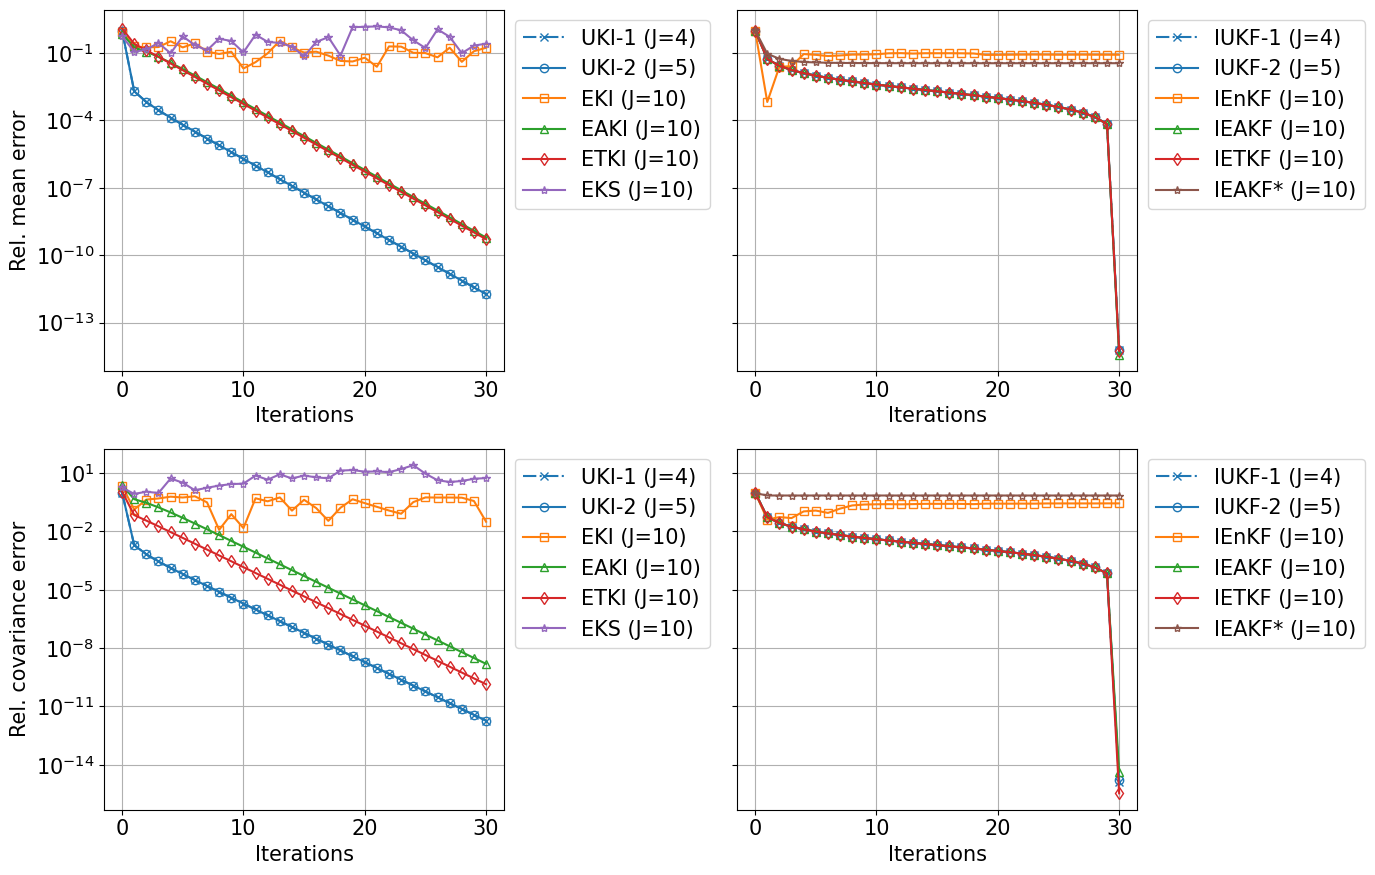

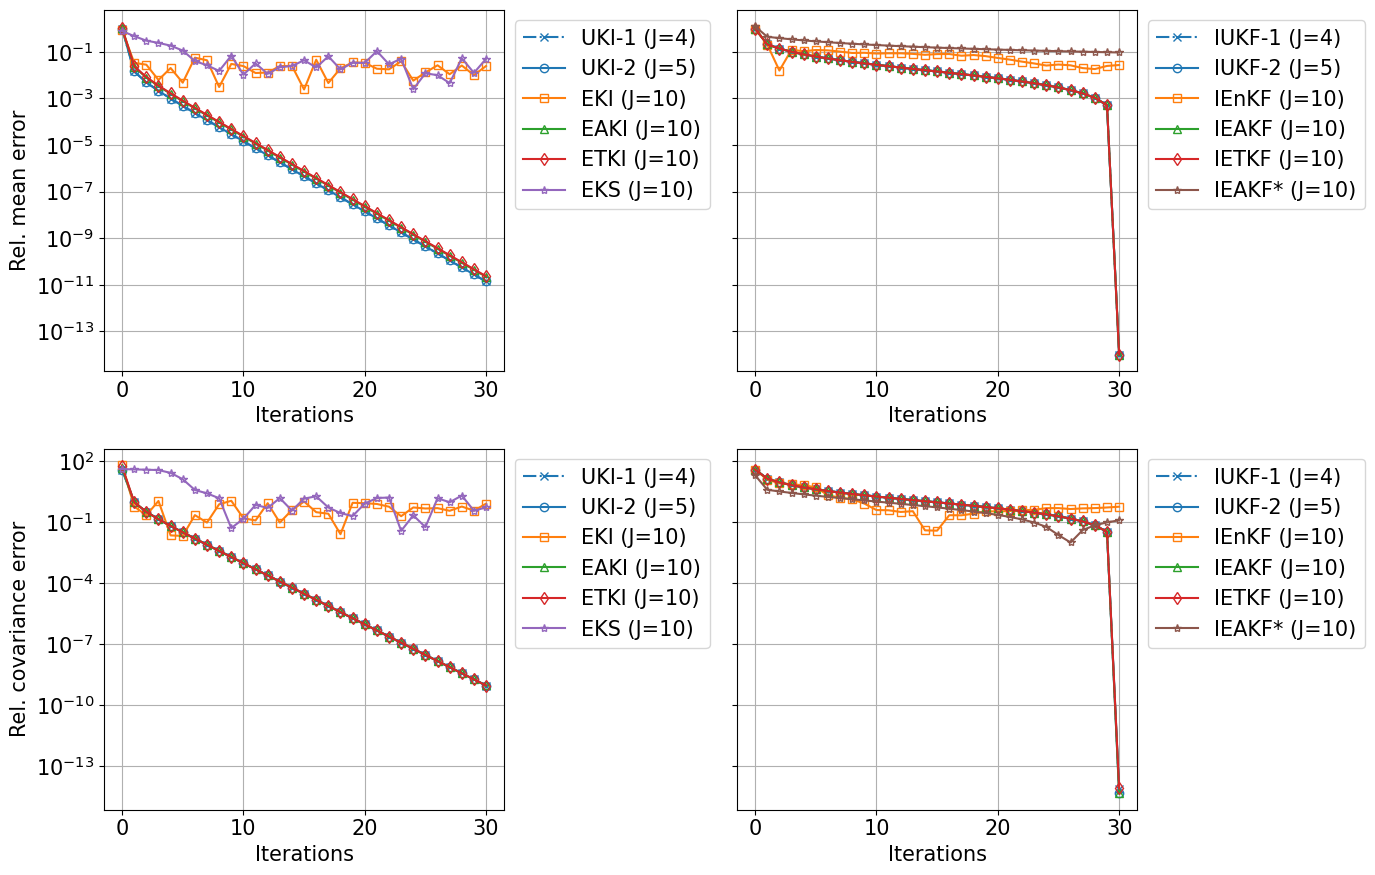

┌ Info: To use the original EKI, uncomment EKI.jl line 88-89
└ @ Main In[104]:63
┌ Info: ("EKS small J t = ", 23.831042766577063)
└ @ Main In[104]:134
┌ Info: ("EKS large J t = ", 23.831042766577063)
└ @ Main In[104]:143
┌ Info: To use the original EKI, uncomment EKI.jl line 88-89
└ @ Main In[104]:63
┌ Info: ("EKS small J t = ", 12.25611990661003)
└ @ Main In[104]:134
┌ Info: ("EKS large J t = ", 12.25611990661003)
└ @ Main In[104]:143


In [104]:
FT = Float64
uki_objs = Dict()
mean_errors = Dict()

Random.seed!(123)
α_reg = 1.0
update_freq = 1
N_iter = 30
N_θ = 2
θ0_mean = zeros(FT, N_θ)
θθ0_cov = Array(Diagonal(fill(1.0^2, N_θ)))
θθ0_cov_sqrt = θθ0_cov
for problem_type in ("under-determined", "over-determined")
    
    θ_post, Σ_post, G, y, Σ_η = Two_Param_Linear_Test(problem_type, θ0_mean, θθ0_cov)
    
    N_y = length(y)
    
    s_param = Setup_Param(G, N_θ, N_y)
    s_param_aug = Setup_Param(G, N_θ, N_y+N_θ)
    
        
    y_aug = [y ;θ0_mean]
    Σ_η_aug = [Σ_η zeros(Float64, N_y, N_θ); zeros(Float64, N_θ, N_y)  θθ0_cov]
     
    
    N_θ_s = 5
    N_θ_l = 10
    
    
    # UKI-1
    uki_obj = UKI_Run(s_param_aug, forward_aug, 
    θ0_mean, θθ0_cov,
    y_aug, Σ_η_aug,
    α_reg,
    update_freq,
    N_iter;
    unscented_transform="modified-n+2")
    
    
    
    # UKI-2
    uki_2np1_obj = UKI_Run(s_param_aug, forward_aug, 
    θ0_mean, θθ0_cov,
    y_aug, Σ_η_aug,
    α_reg,
    update_freq,
    N_iter;
    unscented_transform="modified-2n+1")
    
    original  = false
    eki_y = (original ? y : y_aug)
    eki_Σ_η = (original ? Σ_η : Σ_η_aug)
    eki_s_param = (original ? s_param : s_param_aug)
    eki_forward = (original ? forward : forward_aug) 
    
    

    
    γ_ω = (original ? 0.0 : 1.0)  
    γ_η = ( original ? 1.0 : (γ_ω + 1)/γ_ω ) 
    # EKI
    @info "To use the original EKI, uncomment EKI.jl line 88-89"
    filter_type = "EKI"
    N_ens = N_θ_s
    eki_obj_s = EKI_Run(eki_s_param, eki_forward, 
    filter_type,
    θ0_mean, θθ0_cov_sqrt,
    N_ens,
    eki_y, eki_Σ_η,
    γ_ω, γ_η,
    N_iter)
    
    N_ens = N_θ_l
    eki_obj_l = EKI_Run(eki_s_param, eki_forward, 
    filter_type,
    θ0_mean, θθ0_cov_sqrt,
    N_ens,
    eki_y, eki_Σ_η,
    γ_ω, γ_η,
    N_iter)
    
    # ETKI
    filter_type = "ETKI"
    N_ens = N_θ_s
    etki_obj_s = EKI_Run(eki_s_param, eki_forward, 
    filter_type,
    θ0_mean, θθ0_cov_sqrt,
    N_ens,
    eki_y, eki_Σ_η,
    γ_ω, γ_η,
    N_iter)
    
    N_ens = N_θ_l
    etki_obj_l = EKI_Run(eki_s_param, eki_forward, 
    filter_type,
    θ0_mean, θθ0_cov_sqrt,
    N_ens,
    eki_y, eki_Σ_η,
    γ_ω, γ_η,
    N_iter)
    
    
    # EAKI
    filter_type = "EAKI"
    N_ens = N_θ_s
    eaki_obj_s = EKI_Run(eki_s_param, eki_forward, 
    filter_type,
    θ0_mean, θθ0_cov_sqrt,
    N_ens,
    eki_y, eki_Σ_η,
    γ_ω, γ_η,
    N_iter)
    
    
    N_ens = N_θ_l
    eaki_obj_l = EKI_Run(eki_s_param, eki_forward, 
    filter_type,
    θ0_mean, θθ0_cov_sqrt,
    N_ens,
    eki_y, eki_Σ_η,
    γ_ω, γ_η,
    N_iter)
    
    
    # EKS
    N_ens = N_θ_s
    eks_obj_s = EKS_Run(s_param, forward, 
    θ0_mean, θθ0_cov,
    N_ens,
    y, Σ_η,
    N_iter)
    
    @info "EKS small J t = ", sum(eks_obj_s.Δt)
    
    N_ens = N_θ_l
    eks_obj_l = EKS_Run(s_param, forward, 
    θ0_mean, θθ0_cov,
    N_ens,
    y, Σ_η,
    N_iter)
    
    @info "EKS large J t = ", sum(eks_obj_s.Δt)
    
    
    Nt = N_iter
    ctuki_obj = CTUKI_Run(s_param, forward, 
    θ0_mean, θθ0_cov,
    y, Σ_η,
     Nt;
    unscented_transform="modified-n+2")#unscented_transform)
    
    ctuki_2np1_obj = CTUKI_Run(s_param, forward, 
    θ0_mean, θθ0_cov,
    y, Σ_η,
     Nt ;
    unscented_transform="modified-2n+1")#unscented_transform)
    
    N_ens = N_θ_l
    cteki_obj_l = CTKI_Run("EKI", s_param, forward, θ0_mean, θθ0_cov, N_ens, y, Σ_η, Nt; exact_init=true)
    cteaki_obj_l = CTKI_Run("EAKI", s_param, forward, θ0_mean, θθ0_cov, N_ens, y, Σ_η, Nt; exact_init=true)
    ctetki_obj_l = CTKI_Run("ETKI", s_param, forward, θ0_mean, θθ0_cov, N_ens, y, Σ_η, Nt; exact_init=true)
    
    cteaki_false_obj_l = CTKI_Run("EAKI", s_param, forward, θ0_mean, θθ0_cov, N_ens, y, Σ_η, Nt; exact_init=false)
    
    
    
    
    uki_errors    = zeros(FT, N_iter+1, 2)
    uki_2np1_errors = zeros(FT, N_iter+1, 2)
    eki_s_errors  = zeros(FT, N_iter+1, 2)
    eki_l_errors  = zeros(FT, N_iter+1, 2)
    eaki_s_errors = zeros(FT, N_iter+1, 2)
    eaki_l_errors = zeros(FT, N_iter+1, 2)
    etki_s_errors = zeros(FT, N_iter+1, 2)
    etki_l_errors = zeros(FT, N_iter+1, 2)
    eks_s_errors  = zeros(FT, N_iter+1, 2)
    eks_l_errors  = zeros(FT, N_iter+1, 2)
    
    
    
    ctuki_errors    = zeros(FT, N_iter+1, 2)
    ctuki_2np1_errors = zeros(FT, N_iter+1, 2)
    cteki_l_errors  = zeros(FT, N_iter+1, 2)
    cteaki_l_errors = zeros(FT, N_iter+1, 2)
    ctetki_l_errors = zeros(FT, N_iter+1, 2)
    cteaki_false_l_errors = zeros(FT, N_iter+1, 2)
    
    for i = 1:N_iter+1
        
        
        uki_errors[i, 1] = norm(uki_obj.θ_mean[i] .- θ_post)/norm(θ_post)
        uki_errors[i, 2] = norm(uki_obj.θθ_cov[i] .- Σ_post)/norm(Σ_post)
        
        uki_2np1_errors[i, 1] = norm(uki_2np1_obj.θ_mean[i] .- θ_post)/norm(θ_post)
        uki_2np1_errors[i, 2] = norm(uki_2np1_obj.θθ_cov[i] .- Σ_post)/norm(Σ_post)
        
        eki_s_errors[i, 1] = norm(dropdims(mean(eki_obj_s.θ[i], dims=1), dims=1) .- θ_post)/norm(θ_post)
        eki_s_errors[i, 2] = norm(construct_cov(eki_obj_s.θ[i]) .- Σ_post)/norm(Σ_post)
        
        eki_l_errors[i, 1] = norm(dropdims(mean(eki_obj_l.θ[i], dims=1), dims=1) .- θ_post)/norm(θ_post)
        eki_l_errors[i, 2] = norm(construct_cov(eki_obj_l.θ[i]) .- Σ_post)/norm(Σ_post)
        
        eaki_s_errors[i, 1] = norm(dropdims(mean(eaki_obj_s.θ[i], dims=1), dims=1) .- θ_post)/norm(θ_post)
        eaki_s_errors[i, 2] = norm(construct_cov(eaki_obj_s.θ[i]) .- Σ_post)/norm(Σ_post)
        
        eaki_l_errors[i, 1] = norm(dropdims(mean(eaki_obj_l.θ[i], dims=1), dims=1) .- θ_post)/norm(θ_post)
        eaki_l_errors[i, 2] = norm(construct_cov(eaki_obj_l.θ[i]) .- Σ_post)/norm(Σ_post)
        
        etki_s_errors[i, 1] = norm(dropdims(mean(etki_obj_s.θ[i], dims=1), dims=1) .- θ_post)/norm(θ_post)
        etki_s_errors[i, 2] = norm(construct_cov(etki_obj_s.θ[i]) .- Σ_post)/norm(Σ_post)
        
        etki_l_errors[i, 1] = norm(dropdims(mean(etki_obj_l.θ[i], dims=1), dims=1) .- θ_post)/norm(θ_post)
        etki_l_errors[i, 2] = norm(construct_cov(etki_obj_l.θ[i]) .- Σ_post)/norm(Σ_post)
        
        eks_s_errors[i, 1] = norm(dropdims(mean(eks_obj_s.θ[i], dims=1), dims=1) .- θ_post)/norm(θ_post)
        eks_s_errors[i, 2] = norm(construct_cov(eks_obj_s.θ[i]) .- Σ_post)/norm(Σ_post)
        
        eks_l_errors[i, 1] = norm(dropdims(mean(eks_obj_l.θ[i], dims=1), dims=1) .- θ_post)/norm(θ_post)
        eks_l_errors[i, 2] = norm(construct_cov(eks_obj_l.θ[i]) .- Σ_post)/norm(Σ_post)
        
        ###################
        ctuki_errors[i, 1] = norm(ctuki_obj.θ_mean[i] .- θ_post)/norm(θ_post)
        ctuki_errors[i, 2] = norm(ctuki_obj.θθ_cov[i] .- Σ_post)/norm(Σ_post)
        
        ctuki_2np1_errors[i, 1] = norm(ctuki_2np1_obj.θ_mean[i] .- θ_post)/norm(θ_post)
        ctuki_2np1_errors[i, 2] = norm(ctuki_2np1_obj.θθ_cov[i] .- Σ_post)/norm(Σ_post)
        
        
        cteki_l_errors[i, 1] = norm(dropdims(mean(cteki_obj_l.θ[i], dims=1), dims=1) .- θ_post)/norm(θ_post)
        cteki_l_errors[i, 2] = norm(construct_cov(cteki_obj_l.θ[i]) .- Σ_post)/norm(Σ_post)
        
        
        cteaki_l_errors[i, 1] = norm(dropdims(mean(cteaki_obj_l.θ[i], dims=1), dims=1) .- θ_post)/norm(θ_post)
        cteaki_l_errors[i, 2] = norm(construct_cov(cteaki_obj_l.θ[i]) .- Σ_post)/norm(Σ_post)
        
        cteaki_false_l_errors[i, 1] = norm(dropdims(mean(cteaki_false_obj_l.θ[i], dims=1), dims=1) .- θ_post)/norm(θ_post)
        cteaki_false_l_errors[i, 2] = norm(construct_cov(cteaki_false_obj_l.θ[i]) .- Σ_post)/norm(Σ_post)
        
        
        ctetki_l_errors[i, 1] = norm(dropdims(mean(ctetki_obj_l.θ[i], dims=1), dims=1) .- θ_post)/norm(θ_post)
        ctetki_l_errors[i, 2] = norm(construct_cov(ctetki_obj_l.θ[i]) .- Σ_post)/norm(Σ_post)
        
        
        
        
    end
    
    ites = Array(0:N_iter)
    

    
    
    fig, ax = PyPlot.subplots(nrows = 2, ncols=2, sharex=false, sharey="row", figsize=(14,9))
    ax[1,1].semilogy(ites, uki_errors[:, 1],   "-.x", color = "C0", fillstyle="none", label="UKI-1 (J=$(N_θ+2))")
    ax[1,1].semilogy(ites, uki_2np1_errors[:, 1],   "-o", color = "C0", fillstyle="none", label="UKI-2 (J=$(2*N_θ+1))")
    ax[1,1].semilogy(ites, eki_l_errors[:, 1], "-s", color = "C1", fillstyle="none", label="EKI (J=$N_θ_l)")
    ax[1,1].semilogy(ites, eaki_l_errors[:, 1], "-^", color = "C2", fillstyle="none", label="EAKI (J=$N_θ_l)")
    ax[1,1].semilogy(ites, etki_l_errors[:, 1], "-d", color = "C3", fillstyle="none", label="ETKI (J=$N_θ_l)")
    ax[1,1].semilogy(ites, eks_l_errors[:, 1], "-*", color = "C4", fillstyle="none", label="EKS (J=$N_θ_l)")
    ax[1,1].set_xlabel("Iterations")
    ax[1,1].set_ylabel("Rel. mean error")
    ax[1,1].grid("on")
    ax[1,1].legend(bbox_to_anchor=(1.0, 1.0))
    
    ax[1,2].semilogy(ites, ctuki_errors[:, 1],   "-.x", color = "C0", fillstyle="none", label="IUKF-1 (J=$(N_θ+2))")
    ax[1,2].semilogy(ites, ctuki_2np1_errors[:, 1],   "-o", color = "C0", fillstyle="none", label="IUKF-2 (J=$(2*N_θ+1))")
    ax[1,2].semilogy(ites, cteki_l_errors[:, 1], "-s", color = "C1", fillstyle="none", label="IEnKF (J=$N_θ_l)")
    ax[1,2].semilogy(ites, cteaki_l_errors[:, 1], "-^", color = "C2", fillstyle="none", label="IEAKF (J=$N_θ_l)")
    ax[1,2].semilogy(ites, ctetki_l_errors[:, 1], "-d", color = "C3", fillstyle="none", label="IETKF (J=$N_θ_l)")
    # Initialization
    ax[1,2].semilogy(ites, cteaki_false_l_errors[:, 1], "-*", color = "C5", fillstyle="none", label="IEAKF* (J=$N_θ_l)")
    
    ax[1,2].set_xlabel("Iterations")
    #ax[1,2].set_ylabel("Rel. mean error")
    ax[1,2].grid("on")
    ax[1,2].legend(bbox_to_anchor=(1.0, 1.0))

    ax[2,1].semilogy(ites, uki_errors[:, 2],   "-.x", color = "C0", fillstyle="none", label="UKI-1 (J=$(N_θ+2))")
    ax[2,1].semilogy(ites, uki_2np1_errors[:, 2],   "-o", color = "C0", fillstyle="none", label="UKI-2 (J=$(2*N_θ+1))")
    ax[2,1].semilogy(ites, eki_l_errors[:, 2], "-s", color = "C1", fillstyle="none", label="EKI (J=$N_θ_l)")
    ax[2,1].semilogy(ites, eaki_l_errors[:, 2], "-^", color = "C2", fillstyle="none", label="EAKI (J=$N_θ_l)")
    ax[2,1].semilogy(ites, etki_l_errors[:, 2], "-d", color = "C3", fillstyle="none", label="ETKI (J=$N_θ_l)")
    ax[2,1].semilogy(ites, eks_l_errors[:, 2], "-*", color = "C4", fillstyle="none", label="EKS (J=$N_θ_l)")
    ax[2,1].set_xlabel("Iterations")
    ax[2,1].set_ylabel("Rel. covariance error")
    ax[2,1].grid("on")
    ax[2,1].legend(bbox_to_anchor=(1.0, 1.0))
    
    
    ax[2,2].semilogy(ites, ctuki_errors[:, 2],   "-.x", color = "C0", fillstyle="none", label="IUKF-1 (J=$(N_θ+2))")
    ax[2,2].semilogy(ites, ctuki_2np1_errors[:, 2],   "-o", color = "C0", fillstyle="none", label="IUKF-2 (J=$(2*N_θ+1))")
    ax[2,2].semilogy(ites, cteki_l_errors[:, 2], "-s", color = "C1", fillstyle="none", label="IEnKF (J=$N_θ_l)")
    ax[2,2].semilogy(ites, cteaki_l_errors[:, 2], "-^", color = "C2", fillstyle="none", label="IEAKF (J=$N_θ_l)")
    ax[2,2].semilogy(ites, ctetki_l_errors[:, 2], "-d", color = "C3", fillstyle="none", label="IETKF (J=$N_θ_l)")
    # Initialization
    ax[2,2].semilogy(ites, cteaki_false_l_errors[:, 2], "-*", color = "C5", fillstyle="none", label="IEAKF* (J=$N_θ_l)")
    ax[2,2].set_xlabel("Iterations")
    #ax[2,2].set_ylabel("Rel. covariance error")
    ax[2,2].grid("on")
    ax[2,2].legend(bbox_to_anchor=(1.0, 1.0))
    
    
    fig.tight_layout()
    fig.savefig("Linear-$(problem_type).pdf")
end



In [84]:
θ0 = [-0.460917231898355 -0.24466384828398943; 0.4531087350441114 -0.4097735309861649; -1.4632792899123919 -0.36935156228865923; -0.9136928633909771 0.6677250102530838; -0.07020531287411938 0.15547289219559057; 0.930048598589801 -1.6502771486724697; 1.1101576307107754 1.4998548131494431; 0.32064656397307056 0.34798091787814117; 0.25510596632061405 1.593513952817307; -0.7562111210572589 1.3079640181535492; -1.3078289413198647 0.1789737563190664; -0.9249002586715115 -1.3246320663903752; 1.4604978864124014 0.40317466729527185; -1.3671538155818153 -0.7511695536416849; -0.7672010033414078 -0.11207026718867459; 0.33471116944298857 0.25759124364173175; -1.8957792780289586 0.9709670551471902; -1.7221582400820856 -0.6481502728439678; -0.7767947028663643 -0.35301780484524337; -0.3855474556552954 -0.49084142435029365; -1.738691904111534 -1.2153147453617799; 1.3529863552099044 -0.09986324807255427; 0.028895089394228756 0.4055176294224393; 0.8878468926723762 1.4282231267377496; 0.9835593846903828 0.9972405309688942; -1.5332727616222968 -0.6680105430499622; -0.2197201529894608 -0.23198025127403318; 1.5117349066184282 2.0043482610494205; 0.3959980600720804 0.6159565989861483; -1.340641374486889 -0.9003085550476801; -0.20150262407936323 2.0038901294575506; -1.034803721921635 0.4995290906182742; 1.5216488456230521 -0.4501469010151424; -0.043815377748303894 -1.5125845541746843; -0.4036841360498351 1.5342722174862988; -0.026885502065390435 -1.0906561073624212; -1.1936681858043083 -1.634552811906297; 0.30493095121440605 0.07813572423952701; 0.22055937130055225 1.6225810764641804; 0.651813958010148 0.1605552512036125; 2.008626403274415 -0.44656616846797326; 1.3768542214700543 0.433270744485767; 0.3725229606545057 -1.5883707962412577; -0.5141910817207948 0.2698201381466792; -0.08816612503676194 1.3819008670902966; -0.5552473619859668 -0.7569330382884814; -0.2021409250614968 -0.7779882645062532; -0.5288740627237541 0.10673750107583924; -0.010143937311431492 0.8089717211772929; -0.29003605749322703 0.15585810114488277; -0.21354822505591753 1.4391441281736073; -1.2429049718636471 -0.6208999352348633; 0.5152658643604601 0.6122385537938311; 0.7420364456978407 0.37000716360583; -0.010913966357291407 -0.0260946969747524; 0.18727266629657938 0.286737148552677; -0.7570597374675926 -1.4371929702961899; 1.481864497444113 -1.543870045049729; 2.0830692167373273 -0.8410324154355354; 1.1230404423789668 1.0021919814356726; -0.17733918295951356 -1.8703550705888299; -0.0030207826809281997 -0.8552684200720345; -0.7506469927767306 -0.8115184792975444; 3.2950458236527664 0.14766438513930943; -0.8171972094782382 -0.7434794442463459; -1.2422592254484008 -0.052190076095326894; -0.8547881565657316 0.920318438747021; -0.3528685987401253 -0.6303220459273665; -0.33754501205116455 1.0551631493941025; 1.2433462181289288 0.4290808763327428; -0.9223139293188685 -0.7302698334449971; 0.45476896372175735 1.2402032819131206; -0.44526852024663977 1.2591644622573723; -1.0911883721390727 0.6065398895115758; 1.3421451736471102 -0.513660933473414; -1.6034126998018832 1.964630133489067; -0.2363813346790005 0.7081724811716558; -0.07281183068382957 -1.5631674154079795; 0.027952793265061508 0.19801958904134614; 0.7255973996443743 -1.8996892335619686; -0.3796829156557438 -1.7017969110176092; 0.9977821258619802 0.8025696940886939; 0.2985463808067884 -0.8171384405746998; -1.1064258989768516 0.2690521759991567; 2.279668615941498 1.2960493958729653; 0.34711367239641927 0.7118098691332139; -0.5831811795362709 0.04738707267490939; 0.10104248326840426 1.6890427593331916; -0.10389202772446621 -0.9767982666167281; 0.3908764395612818 2.1478313820003803; -0.5968007500064252 0.2416252366713465; 0.20028110716045575 -1.1444707671626844; 0.46073470974561126 -0.9137831126356663; 0.6942134335300846 -0.5325300019666436; 0.3344700032443659 -1.720953085990861; 1.3089264586976512 -0.20474178689917036; -1.1933952812953335 -1.6626273025404454; -1.1703399134521602 0.16682261719378752; 0.5723667065958116 -0.0757417189512647; 1.3126599293707473 0.11532297159089198]
U1 = [-0.04901431642291916 -0.011360978736451068; 0.03850242770543945 -0.052844982244918; -0.14954118019618112 0.004034393273969443; -0.08000103844586887 0.090951257134895; -0.004596196926089857 0.017242400899589526; 0.06698286986567721 -0.18812321325331693; 0.13161147391096953 0.11699772154161035; 0.03674453225796442 0.025403361248564925; 0.04883628965407885 0.14982033915187745; -0.05496699922283343 0.14962795177651766; -0.12607551441420503 0.05371936293064028; -0.11076639952395526 -0.10486302204616735; 0.1497709413423531 -0.0006281360322863925; -0.1457632705779425 -0.0362044717463714; -0.07719023136413473 0.010145980468310004; 0.03678330629267395 0.016117340420866603; -0.17216100833101583 0.14791148717189992; -0.1791754501937035 -0.01626385395891999; -0.08172183267812257 -0.013307587556120312; -0.04526014751912546 -0.03767472826894322; -0.18924691160957938 -0.07163799328612336; 0.131698513902628 -0.047178415879437906; 0.008881704102399118 0.03912072004880692; 0.10866119950698622 0.1160831468036671; 0.11166649543052147 0.07101601638745902; -0.16087761992433555 -0.023432887798372454; -0.025082525005981043 -0.01677047807784878; 0.1786528156563658 0.15557383770933467; 0.04815159354113069 0.049702335741527465; -0.14537381395958543 -0.05161727124642205; 0.009998315342601182 0.20282125526396105; -0.09442704309689051 0.07773755263489483; 0.1430863043533886 -0.08631542838973655; -0.02683239280202253 -0.14768631402148877; -0.016895680274027408 0.16217406085734332; -0.01888419688043677 -0.10661985599716528; -0.14183746419042803 -0.12795188313415357; 0.03118007496207941 -0.0007258439090786326; 0.0458683419618742 0.1536352791165442; 0.06655360353309005 -0.002188050879522482; 0.19107671199733928 -0.09940556380154966; 0.14198529519392958 0.004643376359858728; 0.013022819083358258 -0.1666392382102047; -0.04659887204106449 0.040754377883396; 0.011894784172758502 0.13846531395622033; -0.06592662789626275 -0.05918382856893466; -0.03148100502455847 -0.0710036761899121; -0.050472202725446634 0.025106160543347068; 0.01104538767939545 0.07991357505933241; -0.02623016125535319 0.02334856727774403; 0.0004046559839575495 0.14756129611824312; -0.1315930140951321 -0.026810778071028572; 0.059836723813107014 0.046044049007130064; 0.07855323613660302 0.01593945923515796; -0.0014628457828419843 -0.002267438757313779; 0.02270367760168783 0.023056323872039677; -0.09592031589600156 -0.12057639229901806; 0.12288670892032721 -0.19288113529497367; 0.19253191710721868 -0.14029096578751227; 0.1254704490663565 0.06765316722422753; -0.04530268166417317 -0.179218713880653; -0.013030559699284136 -0.0841075283186079; -0.08597404289103637 -0.05916326398187994; 0.32655614884722167 -0.07642124699248252; -0.09151215100140203 -0.050628573225037415; -0.12306251989662179 0.02915405894619232; -0.07044197656315677 0.11419003352419548; -0.04411988769882225 -0.052306994999785736; -0.017518032488598238 0.11318580519512299; 0.12878065549970025 0.007916312904351248; -0.10166296676720712 -0.04642658480036336; 0.06323064196252792 0.10952960950348531; -0.025084956540735805 0.13624090584269138; -0.09838426318849806 0.08982793384848217; 0.12447072729603403 -0.08761257139586133; -0.12858741280757122 0.23765515608053714; -0.012725664522162136 0.0762361968252069; -0.030439821185578173 -0.15186516655133628; 0.005699724347946771 0.018721038821768416; 0.04314386579219661 -0.20703113314289323; -0.06271150773562961 -0.1570406528371983; 0.11016830251049235 0.05146040104470776; 0.017222786892046843 -0.08867860321539411; -0.10490871762242562 0.05702693700720734; 0.24370155235821078 0.0646521331073746; 0.044766571495716743 0.06048735352859423; -0.05670169346060612 0.020762926309154137; 0.035092816994797896 0.163476799941452; -0.02476945472229587 -0.09328621572648194; 0.07045391811211694 0.20063840699988472; -0.0551505672372967 0.04025930016577281; 0.0026764399110922993 -0.11818801128939359; 0.031749440189088596 -0.10266918727837956; 0.060408699402353036 -0.07158438119988428; 0.007303082486572278 -0.17863995328899632; 0.12579991848807887 -0.05628621244530595; -0.14222857183913348 -0.130723013207431; -0.11272227484104164 0.04872795736431384; 0.05521499558179096 -0.02325557639466561; 0.1309325444030767 -0.024882736464147903]

100×2 Matrix{Float64}:
 -0.0490143   -0.011361
  0.0385024   -0.052845
 -0.149541     0.00403439
 -0.080001     0.0909513
 -0.0045962    0.0172424
  0.0669829   -0.188123
  0.131611     0.116998
  0.0367445    0.0254034
  0.0488363    0.14982
 -0.054967     0.149628
 -0.126076     0.0537194
 -0.110766    -0.104863
  0.149771    -0.000628136
  ⋮           
 -0.0247695   -0.0932862
  0.0704539    0.200638
 -0.0551506    0.0402593
  0.00267644  -0.118188
  0.0317494   -0.102669
  0.0604087   -0.0715844
  0.00730308  -0.17864
  0.1258      -0.0562862
 -0.142229    -0.130723
 -0.112722     0.048728
  0.055215    -0.0232556
  0.130933    -0.0248827

In [85]:
U1'*U1

2×2 Matrix{Float64}:
  1.0          -6.76625e-17
 -6.76625e-17   1.0

In [93]:
θ0'*θ0

2×2 Matrix{Float64}:
 97.1445   12.2685
 12.2685  102.44